#EXERCISE 7.1

###Expanded MD simulations

I modified the provided code by including tail corrections for potential energy and pressure. These corrections are caused by the need to cut the infinite integration domain during calculations to a finite size (radius) $r_{cut}$ to favor computation.

Calculating the (tail) correction necessary to account for this approximation consists in calculating the excluded part of the integral, $\int_{r_{cut}}^∞$ assuming the radial distribution $g(r) ≃ 1$

Given that the cutoff was used in both potential energy and pressure calculations, we can find what the tails corrections are for these cases, assuming Lennard-Jones potential:



*   $\frac{⟨V_{tail}⟩}{N} ≃ 2\pi\rho N\int_{r_{cut}}^∞dr r^2V_{LJ}(r) = \frac{8 \pi \rho_{LJ} ϵ}{3 r_{cut}^3}(\frac{1}{3 r_{cut}^6} - 1)$
*   $\frac{⟨w_{LJ}⟩_{tail}}{3Nϵ} \simeq \frac{2}{3}\pi\rho\int_{r_{cut}}^∞dr r^2 48[\frac{1}{σ})^{12} - \frac{1}{2}(\frac{1}{\sigma})^6](r) = \frac{32 \pi \rho_{LJ} }{3 r_{cut}^3}(\frac{1}{3 r_{cut}^6} - 1)$



#EXERCISE 7.2

###Corrected values of potential energy per particle, $U/N$



Simulations are run in liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r^\star_c = 2.5$, for 10000 steps.). This has been done for a Molecular Dynamics simulation, and for a Monte Carlo simulation.

Thermodinamic equilibrium must be reached by both simulations in order to evaluate steady-state properties and to efficently compare both simulations. We must therefore face the problem of defining equilibrium parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa import stattools

warnings.filterwarnings("ignore")

path = "NSL_SIMULATOR/OUTPUT/"

For MD simulations, I wrote a code that considers the system at equilibrium if the temperature fluctuations around the average over a period of 100 steps can be considered null (up to a precision of 0.01).

During MD simulations, temperature decreases up to an equilibrium value. I found with trial and error that a starting temperature of 2.0 effectively equilibrates to a value of 1.1, the target value.

The graph below shows that temperature effectively reaches this equilibrium value, therefore the simulation is at its equilibrium state.

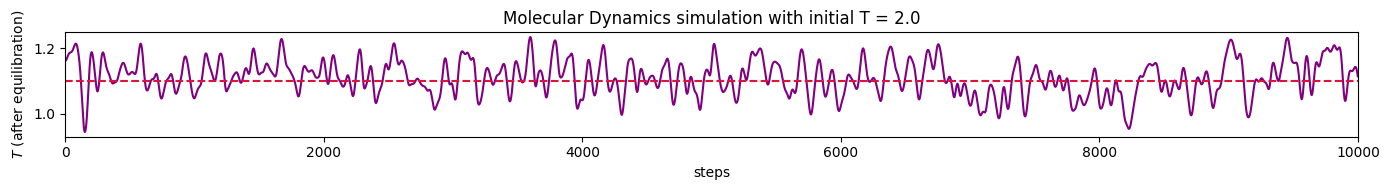

In [2]:
df_temp = pd.read_csv(path + "T_instant_7_02_MD.dat", delim_whitespace=True, header=None)

fig, ax = plt.subplots(1,1, figsize=(14, 2))
ax.plot(df_temp[0], color = 'purple')
ax.set(xlabel = 'steps', ylabel = r'$T$ (after equilibration)', title = 'Molecular Dynamics simulation with initial T = 2.0', xlim = [0, 10000])
ax.axhline(1.1, linestyle = '--', color = 'crimson')

plt.tight_layout()
plt.show()

For the MC simulations, I tweaked the  value of $dt$ in order to get an acceptance ratio of approximately 50%:

I observed that after 200 steps the system can be considered equilibrated. Following simulations are therefore necessarily at equilibrium.

average acceptance rate of MC simulation: 0.5110274


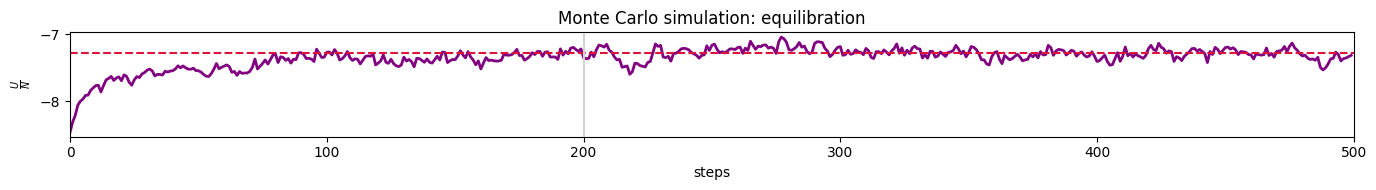

In [3]:
accept = np.loadtxt(path + 'acceptance.dat')
print(f'average acceptance rate of MC simulation: {accept[:,1].mean()}')

df_U_eq = pd.read_csv(path + "U_equilibration_MC.dat", delim_whitespace=True, header=None)

fig, ax = plt.subplots(1,1, figsize=(14, 2))
ax.plot(df_U_eq[0], color = 'purple', lw=2)
ax.set(xlabel = 'steps', ylabel = r'$\frac{U}{N}$', title = 'Monte Carlo simulation: equilibration', xlim = [0, 500])
ax.axhline(df_U_eq[0][200:].mean(), linestyle='--', color='crimson')
ax.axvline(200, color='lightgrey')

plt.tight_layout()
plt.show()

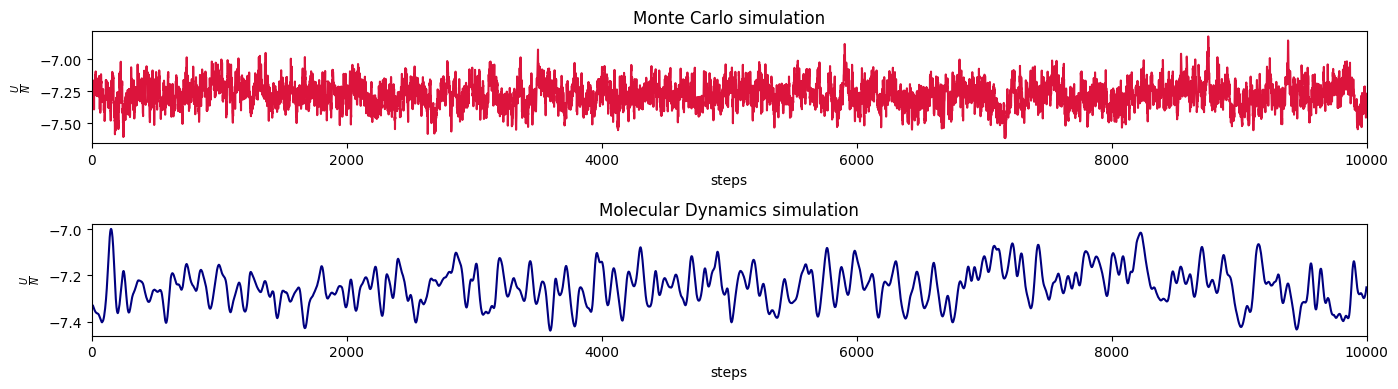

In [5]:
df_md = pd.read_csv(path + "U_instant_7_02_MD.dat", delim_whitespace=True, header=None)
df_mc = pd.read_csv(path + "U_instant_7_02_MC.dat", delim_whitespace=True, header=None)

U_md = df_md[0].values
U_md = U_md - np.mean(U_md)
U_mc = df_mc[0].values
U_mc = U_mc - np.mean(U_mc)

fig, ax = plt.subplots(2,1, figsize=(14, 4))
ax[0].plot(df_mc[0], color = 'crimson')
ax[1].plot(df_md[0], color = 'navy')
ax[0].set(xlabel = 'steps', ylabel = r'$\frac{U}{N}$', title = 'Monte Carlo simulation', xlim = [0, 10000])
ax[1].set(xlabel = 'steps', ylabel = r'$\frac{U}{N}$', title = 'Molecular Dynamics simulation', xlim = [0, 10000])

plt.tight_layout()
plt.show()

We can see that with these conditions, the system has indeed reached equilibrium, as the $\frac{U}{N}$ values oscillate roughly around the same average value

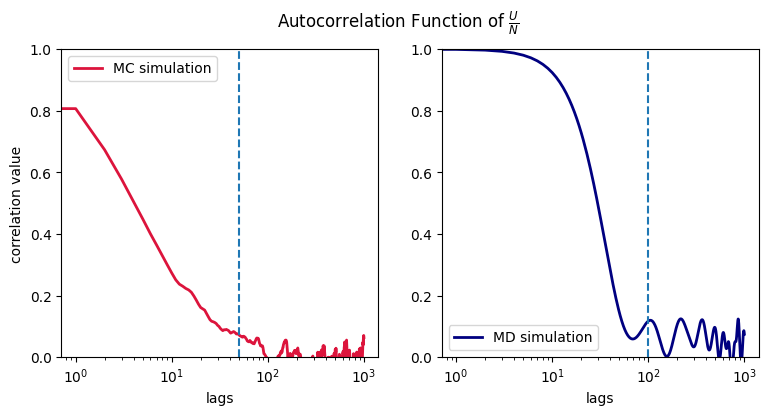

In [6]:
nlags = int(len(U_md)/10)

ac_md = stattools.acf( U_md, nlags=nlags)
ac_mc = stattools.acf( U_mc, nlags=nlags)

fig, ax = plt.subplots(1,2, figsize=(9, 4))
ax[0].plot(ac_mc, color='crimson', lw = 2, label = 'MC simulation')
ax[1].plot(ac_md, color='navy', lw = 2, label = 'MD simulation')
ax[0].set(ylim = [0,1], xlabel = 'lags', ylabel = 'correlation value', xscale = 'log')
ax[1].set(ylim = [0,1], xlabel = 'lags', xscale = 'log') #xlim = [0,nlags]
ax[0].legend()
ax[1].legend()

ax[0].axvline(50, linestyle='--')
ax[1].axvline(100, linestyle='--')

fig.suptitle(r'Autocorrelation Function of $\frac{U}{N}$')

plt.show()
plt.close()

An analysis of the autocorrelation function of $\frac{U}{N}$ shows a decreasing ACF, that becomes negligible after 50 to 100 steps for both simulations. This is the system's memory: how many steps back in time do previous configurations effectively influence the current one.

This is therefore a useful statystic to understand the dimension of blocks necessary while using data blocking of quantities evaluated with these simulations.



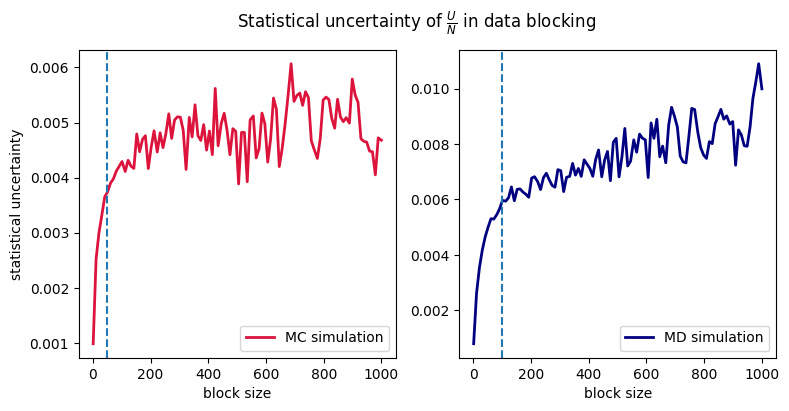

In [7]:
def data_blocking(x, blk_size):

  num_blk = len(x)//blk_size

  blk_mean = [0]*num_blk
  blk_squares_accu = [0]*num_blk
  blk_accu = [0]*num_blk
  errors = [0]*num_blk

  for blk in range(num_blk):
    blk_mean[blk] = np.mean(x[blk*blk_size:(blk+1)*blk_size])
    if blk == 0:
      blk_accu[0] = blk_mean[0]
      blk_squares_accu[0] = blk_mean[0]*blk_mean[0]
      errors[0] = 0
    else:
      blk_accu[blk] = np.mean(blk_mean[:blk+1])
      blk_squares_accu[blk] = np.mean(np.square(blk_mean[:blk+1]))
      #blk_accu[blk] = blk_accu[blk-1]*(blk-1)/blk + blk_mean[blk]/blk
      #blk_squares_accu[blk] = blk_squares_accu[blk-1]*(blk-1)/blk + blk_mean[blk]*blk_mean[blk]/blk
      errors[blk] = np.sqrt((blk_squares_accu[blk] - blk_accu[blk]*blk_accu[blk])/(blk))

  return blk_accu, errors

U_md = df_md[0].values
U_mc = df_mc[0].values

#blk_sizes = np.logspace(1, np.log10(5000), 30, dtype=int)
blk_sizes = np.linspace(1, 1000, 100, dtype=int)

errors_to_graph_md = []
errors_to_graph_mc = []

for this_size in blk_sizes:
  _, errors_md = data_blocking(U_md, this_size)
  _, errors_mc = data_blocking(U_mc, this_size)
  errors_to_graph_md.append(errors_md[-1])
  errors_to_graph_mc.append(errors_mc[-1])

fig, ax = plt.subplots(1,2, figsize=(9, 4))
ax[0].plot(blk_sizes, errors_to_graph_mc, color='crimson', lw = 2, label = 'MC simulation')
ax[1].plot(blk_sizes, errors_to_graph_md, color='navy', lw = 2, label = 'MD simulation')

ax[0].set(xlabel = 'block size', ylabel = 'statistical uncertainty')
ax[1].set(xlabel = 'block size')
ax[0].legend()
ax[1].legend()

ax[0].axvline(50, linestyle='--')
ax[1].axvline(100, linestyle='--')

fig.suptitle(r'Statistical uncertainty of $\frac{U}{N}$ in data blocking')

plt.show()
plt.close()

Similarly, we can see that after reaching a block size compatible with the number of correlation lags found previously, statistical uncertainty slows its growth and roughly reaches a plateau. The greater fluctuations of the uncertainty seen in the plot above could be explained by the decreasing total number of blocks as the block size increases.

# EXERCISE 7.3 and 7.4

###Computing the Radial Distribution Function $g(r)$

Here are average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ obtained with the equilibrated simulations. Values were calculated using data blocking with 20 blocks of 1000 points each (well above the memory length analized before).

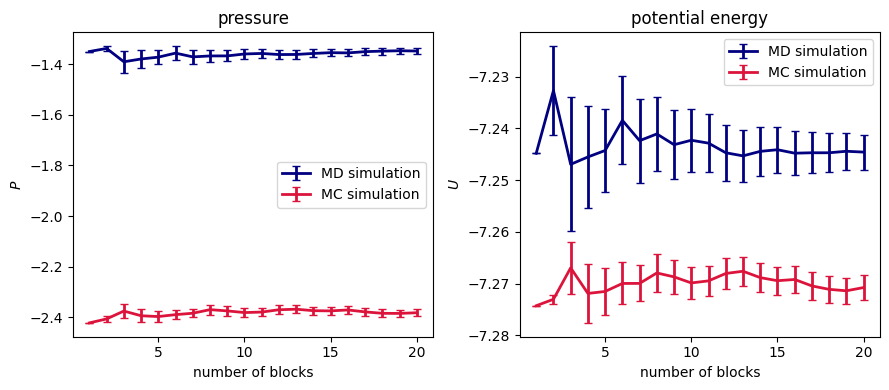

In [8]:
df_P_md = pd.read_csv(path + "pressure_MD.dat", comment = '#', delim_whitespace=True, header=None)
df_P_md.columns = ['block', 'block value', 'ave', 'error']
df_P_mc = pd.read_csv(path + "pressure_MC.dat", comment = '#', delim_whitespace=True, header=None)
df_P_mc.columns = ['block', 'block value', 'ave', 'error']

df_U_md = pd.read_csv(path + "potential_energy_MD.dat", comment = '#', delim_whitespace=True, header=None)
df_U_md.columns = ['block', 'block value', 'ave', 'error']
df_U_mc = pd.read_csv(path + "potential_energy_MC.dat", comment = '#', delim_whitespace=True, header=None)
df_U_mc.columns = ['block', 'block value', 'ave', 'error']

fig, ax = plt.subplots(1,2, figsize = (9, 4))

ax[0].errorbar(df_P_md['block'], df_P_md['ave'], yerr=df_P_md['error'], color = 'navy', lw = 2, capsize = 3, label = 'MD simulation')
ax[0].errorbar(df_P_mc['block'], df_P_mc['ave'], yerr=df_P_mc['error'], color = 'crimson', lw = 2, capsize = 3, label = 'MC simulation')
ax[0].set(xlabel = 'number of blocks', ylabel = r'$P$', title = 'pressure')
ax[0].legend()

ax[1].errorbar(df_U_md['block'], df_U_md['ave'], yerr=df_U_md['error'], color = 'navy', lw = 2, capsize = 3, label = 'MD simulation')
ax[1].errorbar(df_U_mc['block'], df_U_mc['ave'], yerr=df_U_mc['error'], color = 'crimson', lw = 2, capsize = 3, label = 'MC simulation')
ax[1].set(xlabel = 'number of blocks', ylabel = r'$U$', title = 'potential energy')
ax[1].legend()


plt.tight_layout()
plt.show()
plt.close()

In order to obtain $g(r)$ all distances between each particle pair are calculated, for every configuration of the system. For each distance, the counter relative to the bin it falls into is increased by two, (pair simmetry). The histogram is then normalized by dividing by $ρ N_{part}\frac{4}{3}π((r + b)^3 - r^3)$ where $b$ is the bin size.

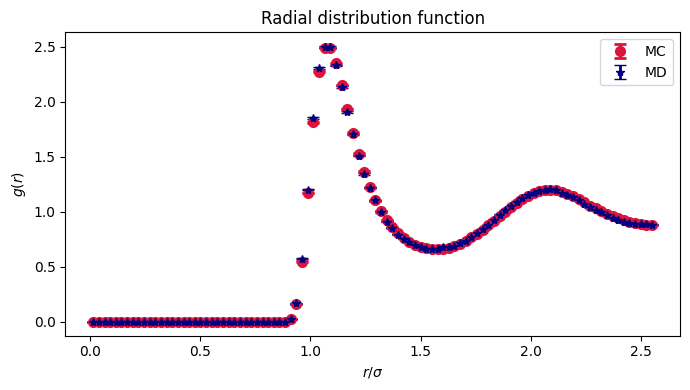

In [11]:
gofr_MD = pd.read_csv(path + 'gofr_MD.dat', delim_whitespace=True, comment='#', header=None)
gofr_MD.columns = ['r', 'g(r)', 'error']
gofr_MC = pd.read_csv(path + 'gofr_MC.dat', delim_whitespace=True, comment='#', header=None)
gofr_MC.columns = ['r', 'g(r)', 'error']

fig, ax = plt.subplots(1,1, figsize=(7, 4))
ax.errorbar(gofr_MC['r'][-100:], gofr_MC['g(r)'][-100:], yerr = gofr_MC['error'][-100:], fmt = "o",color="crimson", label="MC", capsize=4, elinewidth=2, markeredgewidth=2)
ax.errorbar(gofr_MD['r'][-100:], gofr_MD['g(r)'][-100:], yerr = gofr_MD['error'][-100:], label="MD", fmt='*',color="navy", capsize=4, elinewidth=2)
ax.set(xlabel = r'$r/\sigma$', ylabel = r'$g(r)$', title = 'Radial distribution function')
ax.legend()

plt.tight_layout()
plt.show()
plt.close()

We can see that the pressure and energy values are not precisely compatible among themselves, while the radial distribution function most definitely is.